In [1]:
%pylab inline
import os
from importlib import reload

import torch
from torch import nn
import torchvision
from torchinfo import summary
from torch.utils.data import DataLoader

import PIL
import tqdm

from smlm_dl import config, dataset, fileloader, model, trainer

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
print(list(config.config.keys()))

# print(config.config["TEST_DATASET_PATH"]["Hagen"])
high_snr_fpath = os.path.join(config.config["TEST_DATASET_PATH"]["Hagen"], r"01-actin-60x-noise1","actin-60x-noise1-highsnr.tif")
low_snr_fpath = os.path.join(config.config["TEST_DATASET_PATH"]["Hagen"], r"01-actin-60x-noise1","actin-60x-noise1-lowsnr.tif")
print(high_snr_fpath, "\n", low_snr_fpath)

image_out_size = (32, 32)

['DEFAULT', 'LOG_PATH', 'ID', 'TEST_DATASET_PATH']
/home/kkc29/project/datasets/Hagen/01-actin-60x-noise1/actin-60x-noise1-highsnr.tif 
 /home/kkc29/project/datasets/Hagen/01-actin-60x-noise1/actin-60x-noise1-lowsnr.tif


100
torch.Size([1, 1, 2048, 2048])
torch.Size([1, 1024, 8464])
torch.Size([8464, 1, 32, 32])


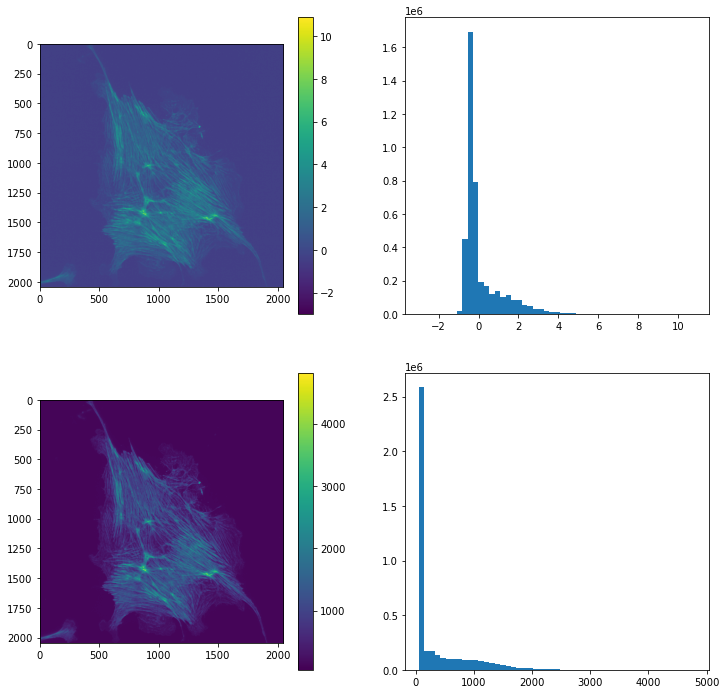

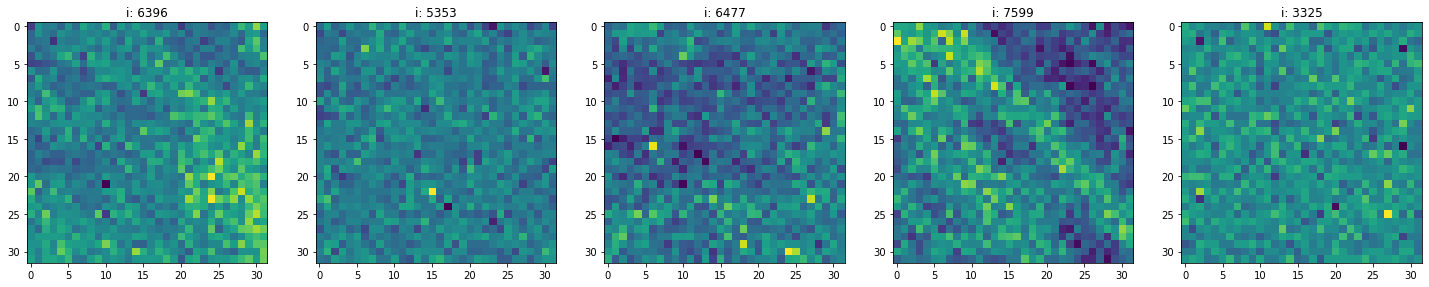

In [3]:
image_i = 0

images = fileloader.PilImageFileLoader(low_snr_fpath, slices=None, stack_to_volume=False, cache=True)
images.images = torch.as_tensor(images.images)
torchvision.transforms.functional.normalize(images.images, 112.49488067626953, 20.180103302001953, True)
images_high_snr = fileloader.PilImageFileLoader(high_snr_fpath, slices=None, stack_to_volume=False, cache=True)
print(len(images))
print(images[image_i].shape)
fig, axes = subplots(2, 2, figsize=(12,12))
im = axes[0,0].imshow(images[image_i][0,0])
colorbar(im, ax=axes[0,0])
axes[0,1].hist(images[image_i][0,0].detach().cpu().numpy().flatten(), 51)

im = axes[1,0].imshow(images_high_snr[image_i][0,0])
colorbar(im, ax=axes[1,0])
axes[1,1].hist(images_high_snr[image_i][0,0].flatten(), 51)

patches = nn.functional.unfold(torch.as_tensor(images[image_i]), 32, stride=32-10)
print(patches.shape)

patches = torch.movedim(patches, -1, 0).reshape(-1, 1, 32, 32)
print(patches.shape)

cols = 5
fig, axes = subplots(1, cols, figsize=(5*cols, 5))
for i, j in enumerate(np.random.choice(patches.shape[0], size=cols, replace=False)):
    axes[i].imshow(patches[j,0])
    axes[i].set_title("i: {}".format(j))

torch.Size([1, 1, 2048, 2048])
(1, 1, 2048, 2048)
tensor(0.2239) tensor(0.0700)
x0,  [tensor(1.3829), tensor(-0.2396)]
loss 0.0009483584435656667
Parameter containing:
tensor([1.3127], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-0.2239], device='cuda:0', requires_grad=True)
PSNR: 30.230274847713826


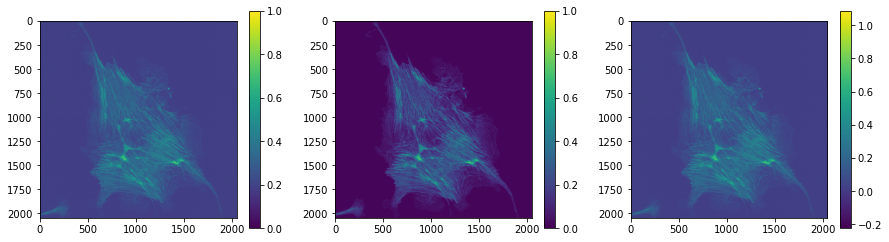

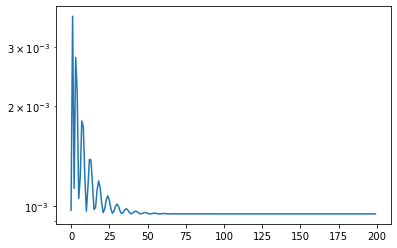

In [4]:
i = 0
print(images[i].shape)
print(images_high_snr[i].shape)

img_low_res = torch.as_tensor(images[i])
img_low_res -= img_low_res.min()
img_low_res /= img_low_res.max()

img_high_res = torch.as_tensor(images_high_snr[i])
img_high_res -= img_high_res.min()
img_high_res /= img_high_res.max()
print(img_low_res.mean(), img_high_res.mean())


x0 = [np.sqrt(img_high_res.var() / img_low_res.var())]
x0.append(-(img_low_res*x0[0]-img_high_res).mean())



# x0 = [15, -1500]
print('x0, ', x0)

fig, axes = subplots(1, 3, figsize=(15,4))
im = axes[0].imshow(img_low_res[0,0])
colorbar(im, ax=axes[0])
im = axes[1].imshow(img_high_res[0,0], )
colorbar(im, ax=axes[1])

class Scale_Offset(nn.Module):
    def __init__(self, x0):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1)*x0[0])
        self.offset = nn.Parameter(torch.ones(1)*x0[1])
    
    def forward(self, x):
        return x * self.scale + self.offset

fit_model = Scale_Offset(x0)
optim_func = torch.optim.Adamax(fit_model.parameters(), lr=1e-1)
loss_func = nn.MSELoss()

fit_model = fit_model.to("cuda")
img_low_res = img_low_res.to("cuda")
img_high_res = img_high_res.to("cuda")

loss_log = list()
for i in range(200):
    optim_func.zero_grad()
    pred = fit_model(img_low_res)
    loss = loss_func(pred, img_high_res)
    loss.backward()
    optim_func.step()
    loss_log.append(loss.item())

print('loss', loss.item())
subplots(1,1)
plot(loss_log)
yscale('log')
print(fit_model.scale, fit_model.offset)

print("PSNR: {}".format(10*np.log10(1/loss.detach().cpu().numpy())))

scaled_img_low_res = fit_model(img_low_res).detach().cpu().numpy()

im = axes[2].imshow(scaled_img_low_res[0,0], )
colorbar(im, ax=axes[2])



# from scipy import optimize

# def compare_images(p, img_a, img_b):
#     offset, scale = p
    
#     return nn.functional.mse_loss((img_a-img_a.mean()) * scale + offset, img_b)

# res = optimize.least_squares(compare_images, x0=x0, args=(img_low_res, img_high_res))
# print(res)

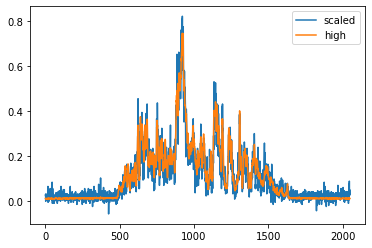

In [5]:

plot(scaled_img_low_res[0,0,scaled_img_low_res.shape[2]//2,:], label='scaled')
# plot(img_low_res[0,0,img_low_res.shape[2]//2,:].detach().cpu().numpy(), label='low')
plot(img_high_res[0,0,img_high_res.shape[2]//2,:].detach().cpu().numpy(), label='high')
legend()


In [6]:
from skimage import metrics
print(metrics.structural_similarity(img_low_res[0,0].detach().cpu().numpy(), img_high_res[0,0].detach().cpu().numpy()))
print(metrics.structural_similarity(scaled_img_low_res[0,0], img_high_res[0,0].detach().cpu().numpy()))

0.32697147378535474
0.836753322622367


In [7]:
img_high_res.min(), img_high_res.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [8]:
dir_path = os.path.join(config.config["LOG_PATH"]["run"], "2022-04-25_19-22-09_c18n07.farnam.hpc.yale.internal_3_part_compete_l1_reg") # no reg


training = trainer.FittingTrainer.from_model_file(dir_path)
training.load_checkpoint(dir_path)

No training data supplied. Remember to set prior to training.
No validation data supplied. Remember to set prior to training.
Device: cuda
Loaded from /home/kkc29/scratch60/runs/2022-04-25_19-22-09_c18n07.farnam.hpc.yale.internal_3_part_compete_l1_reg, last modified: Mon Apr 25 19:24:02 2022
Layer (type:depth-idx)                        Param #
BaseFitModel                                  --
├─DirectImageMapperModel: 1-1                 --
│    └─ModuleDict: 2-1                        --
├─PassthroughRenderer: 1-2                    --
├─UnetEncoderModel: 1-3                       --
│    └─ModuleDict: 2-2                        --
│    │    └─Sequential: 3-1                   2,480
│    │    └─Sequential: 3-2                   --
│    │    └─Sequential: 3-3                   13,888
│    │    └─Sequential: 3-4                   --
│    │    └─Sequential: 3-5                   55,424
│    │    └─Sequential: 3-6                   --
│    │    └─Sequential: 3-7                   221,440


In [9]:
test_loader = DataLoader(patches, batch_size=256)
training.model.eval()
res = torch.empty(patches.shape, requires_grad=False)
for i, data in enumerate(tqdm.tqdm(test_loader)):
    # res.append(training.model(data))    
    res[i*256:(i+1)*256,:,:,:] = training.model(data.to("cuda")).detach()    

# res = torch.concat(res)
print(res.shape)

100%|██████████| 34/34 [00:00<00:00, 43.42it/s]

torch.Size([8464, 1, 32, 32])


In [10]:
res2 = res.clone()
res2[:,:,:5] = 0
res2[:,:,-5:] = 0
res2[:,:,:,:5] = 0
res2[:,:,:,-5:] = 0
res2 = torch.movedim(res2.reshape(-1, 1, 32*32), 0, -1)
print(res2.shape)
reconstruction = nn.functional.fold(res2, 2048, 32, stride=22)
print(reconstruction.shape)
# reconstruction = nn.functional.pad(reconstruction, (5,5,4,6), value=0)
# print(reconstruction.shape)

torch.Size([1, 1024, 8464])
torch.Size([1, 1, 2048, 2048])


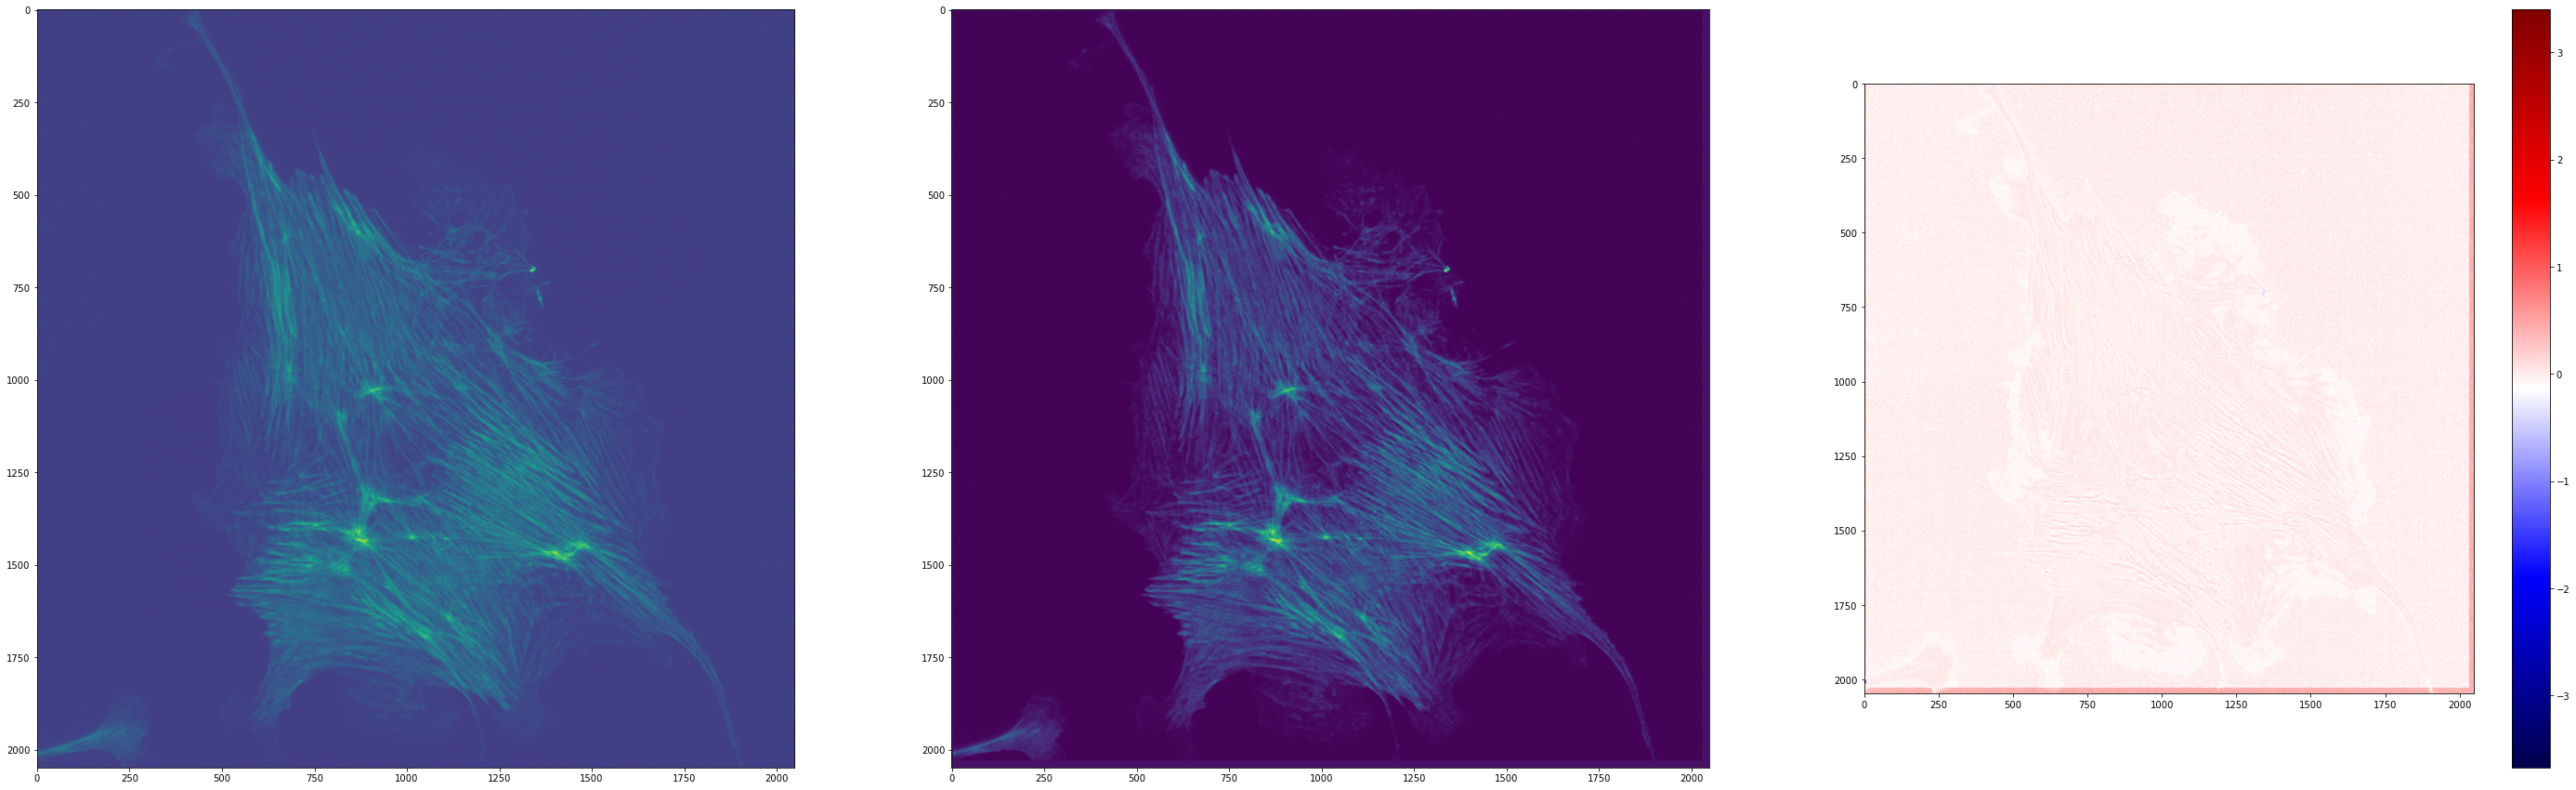

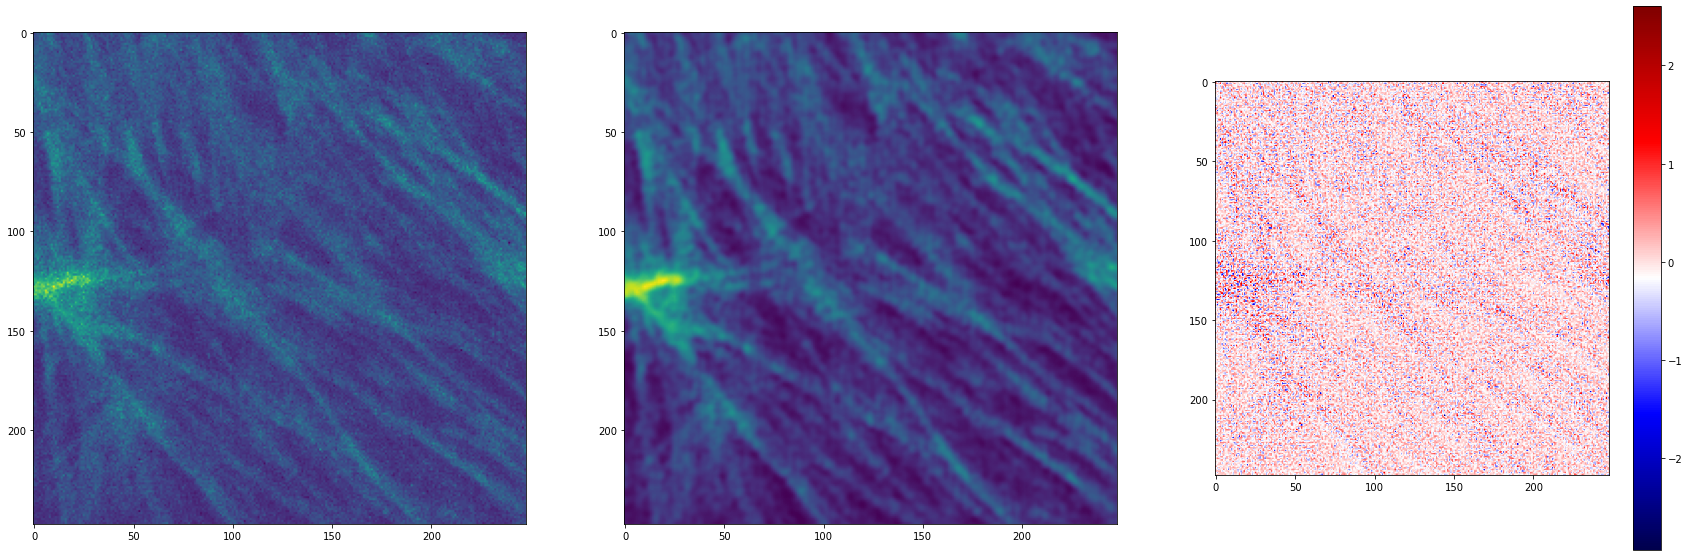

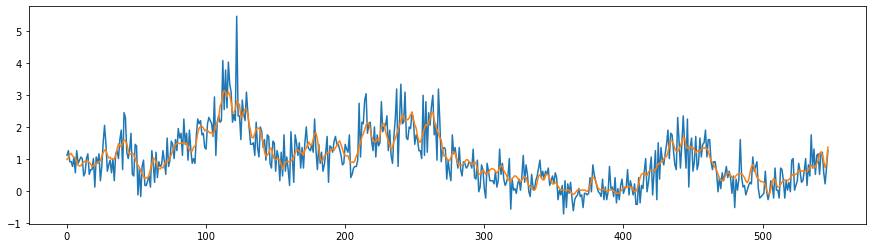

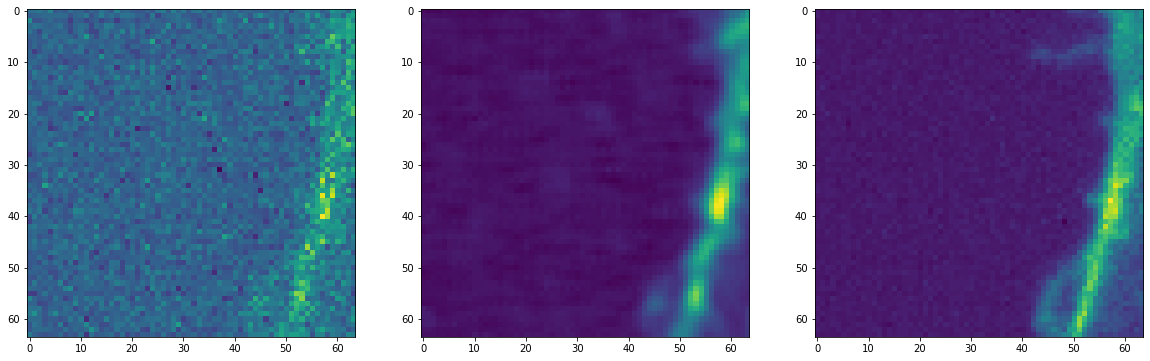

In [16]:
vmin, vmax = None, None

fig, axes = subplots(1, 3, figsize=(50, 15))
axes[0].imshow(images[image_i][0,0], vmin=vmin, vmax=vmax)
axes[1].imshow(reconstruction[0,0], vmin=vmin, vmax=vmax)
diff = reconstruction[0,0]-images[image_i][0,0]
im = axes[2].imshow(diff, cmap='seismic', vmin=None, vmax=None)
colorbar(im, ax=axes[2])

slc = slice(900,-900), slice(900,-900)
fig, axes = subplots(1, 3, figsize=(30, 10))
axes[0].imshow(images[image_i][0,0][slc], vmin=vmin, vmax=vmax)
axes[1].imshow(reconstruction[0,0][slc], vmin=vmin, vmax=vmax)
im = axes[2].imshow(reconstruction[0,0][slc] - images[image_i][0,0][slc], cmap='seismic', vmin=None, vmax=None)
colorbar(im, ax=axes[2])

slc = slice(750,-750), slice(700,701)
fig, ax = subplots(1, 1, figsize=(15,4))
ax.plot(images[image_i][0,0][slc])
ax.plot(reconstruction[0,0][slc])

w = 64
dx = np.random.randint(0, reconstruction.shape[2]-w)
dy = np.random.randint(0, reconstruction.shape[3]-w)
slc = (slice(dx, dx+w), slice(dy, dy+w))
fig, axes = subplots(1, 3, figsize=(20, 10))
axes[0].imshow(images[image_i][0,0][slc])
axes[1].imshow(reconstruction[0,0][slc])
axes[2].imshow(images_high_snr[image_i][0,0][slc])


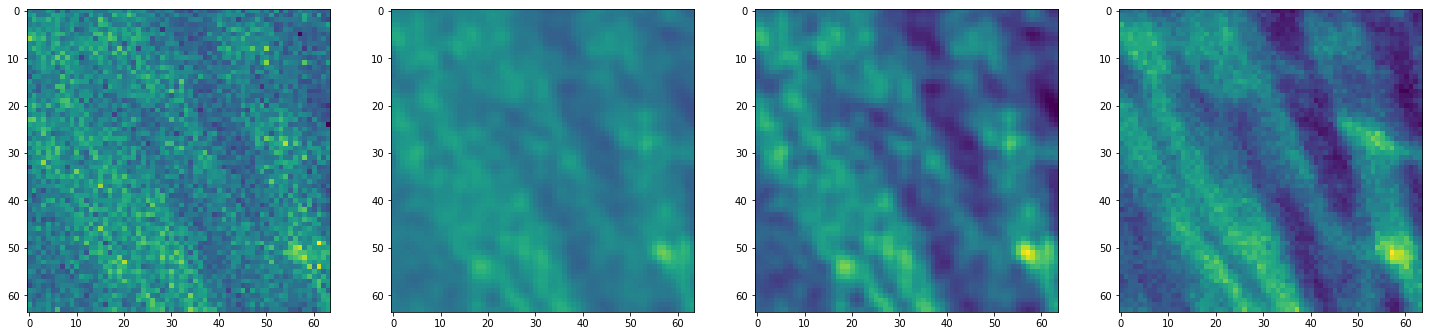

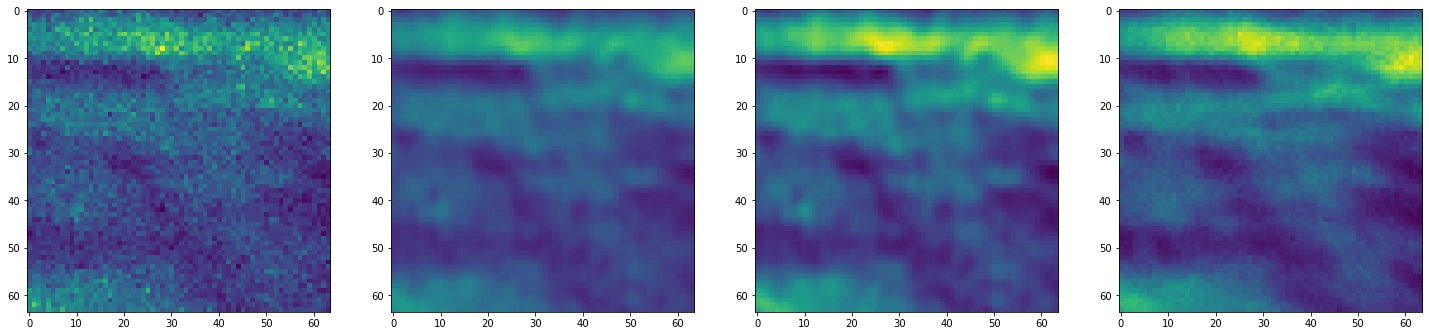

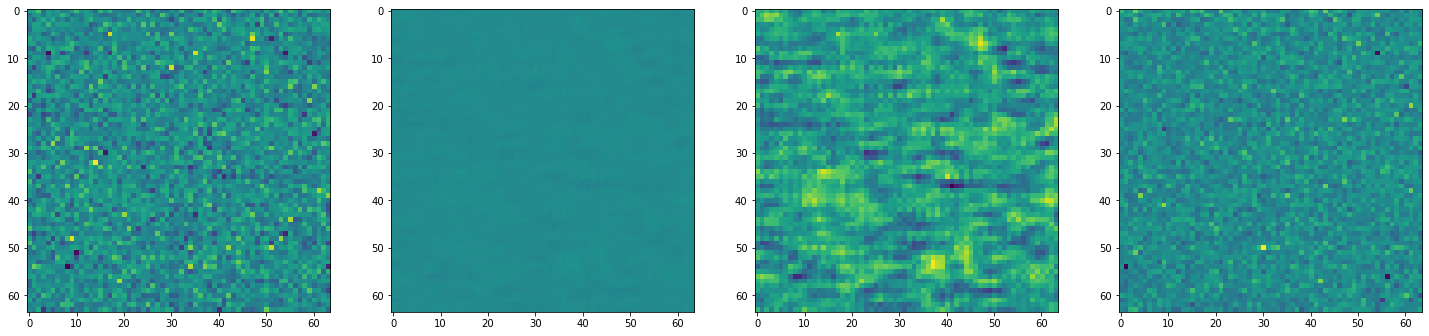

In [22]:
for i in range(3):
    w = 64
    dx = np.random.randint(0, reconstruction.shape[2]-w)
    dy = np.random.randint(0, reconstruction.shape[3]-w)
    slc = (slice(dx, dx+w), slice(dy, dy+w))
    
    image_low_snr_crop = images[image_i][0,0][slc] * 40
    image_low_snr_pred_crop = reconstruction[0,0][slc] * 40
    image_high_snr_crop = images_high_snr[image_i][0,0][slc]
    
    _min = min([image_low_snr_crop.min(), image_low_snr_pred_crop.min(), ])
    _max = max([image_low_snr_crop.max(), image_low_snr_pred_crop.max(), ])
    # _min = None
    # _max = None
    
    fig, axes = subplots(1, 4, figsize=(25, 10))
    axes[0].imshow(image_low_snr_crop, vmin=_min, vmax=_max)
    axes[1].imshow(image_low_snr_pred_crop, vmin=_min, vmax=_max)
    axes[2].imshow(image_low_snr_pred_crop, )
    axes[3].imshow(image_high_snr_crop, )
    
    # fig, axes = subplots(1, 3, figsize=(20, 10))
    # axes[0].imshow(images[image_i][0,0][slc])
    # axes[1].imshow(reconstruction[0,0][slc])
    # axes[2].imshow(images_high_snr[image_i][0,0][slc])

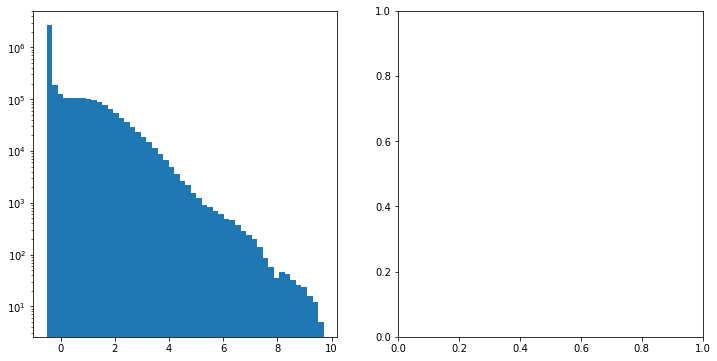

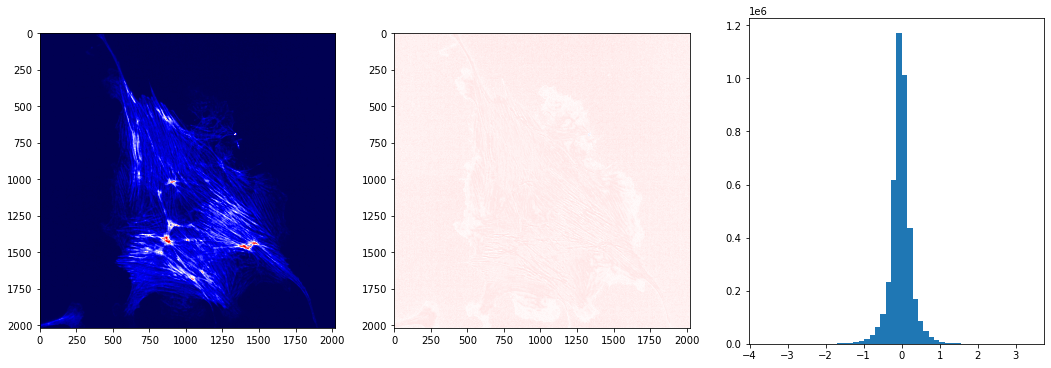

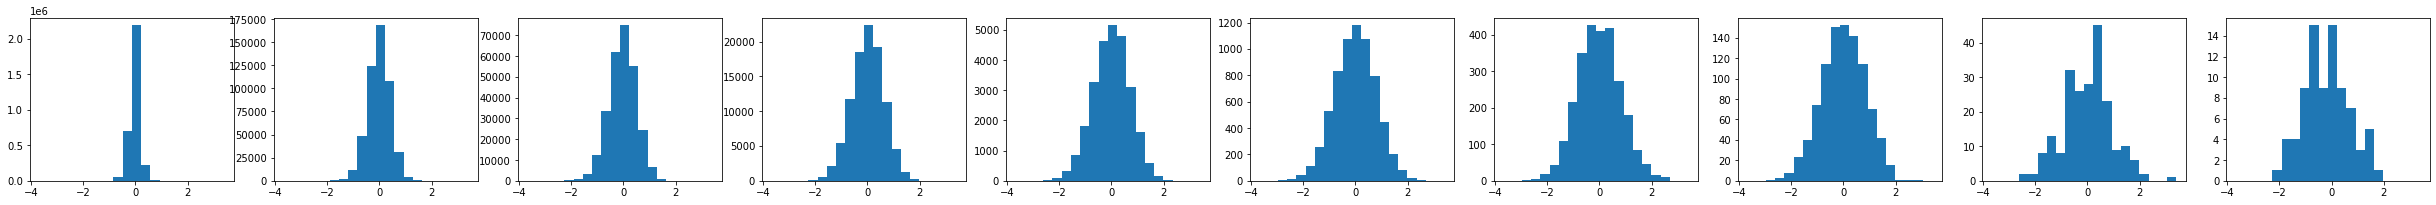

In [13]:
reconstruction_cropped = reconstruction[0,0,5:-22, 5:-22].detach().cpu().numpy()
diff_cropped = diff[5:-22, 5:-22].detach().cpu().numpy()
fig, axes = subplots(1, 2, figsize=(12, 6))
axes[0].hist(reconstruction_cropped.flatten(), 50)
axes[0].set_yscale('log')

fig, axes = subplots(1, 3, figsize=(18,6))
axes[0].imshow(reconstruction_cropped, cmap='seismic')
axes[1].imshow(diff_cropped, cmap='seismic')
axes[2].hist(diff_cropped.flatten(), 50)

_min = diff_cropped.min()
_max = diff_cropped.max()

splits = np.linspace(reconstruction_cropped.min(), reconstruction_cropped.max(), 11)
fig, axes = subplots(1, len(splits)-1, figsize=(4*len(splits)-1,3))
for i, split in enumerate(splits[:-1]):
    diff_cropped_filtered = diff_cropped[np.logical_and(reconstruction_cropped>split, reconstruction_cropped<splits[i+1])]
    axes[i].hist(diff_cropped_filtered, bins=np.linspace(_min, _max, 21))

x0,  [2.118541955947876, 0.0452100694179535]
loss 0.00016827744548209012
Parameter containing:
tensor([1.0501], device='cuda:0', requires_grad=True) Parameter containing:
tensor([0.0088], device='cuda:0', requires_grad=True)


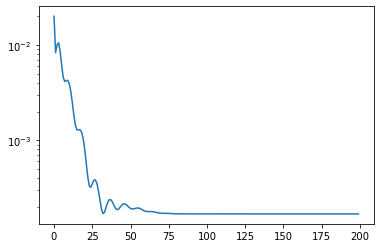

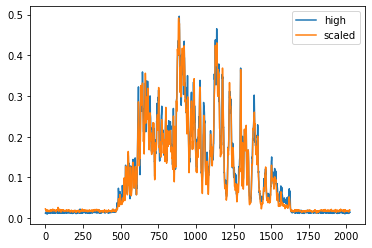

In [14]:
class Scale_Offset(nn.Module):
    def __init__(self, x0):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1)*x0[0])
        self.offset = nn.Parameter(torch.ones(1)*x0[1])
    
    def forward(self, x):
        return x * self.scale + self.offset
    
    
img_low_res = reconstruction[0,0,5:-20,5:-20].to("cuda")
img_low_res -= img_low_res.min()
img_low_res /= img_low_res.max()

img_high_res = torch.as_tensor(images_high_snr[image_i][0,0,5:-20,5:-20]).to("cuda")
img_high_res -= img_high_res.min()
img_high_res /= img_high_res.max()
    
x0 = [torch.sqrt(img_high_res.var() / img_low_res.var()).item() * 2]
x0.append(-(img_low_res*x0[0]-img_high_res).mean().item()+0.1)

# x0 = [15, -1500]
print('x0, ', x0)    

fit_model = Scale_Offset(x0)
optim_func = torch.optim.Adamax(fit_model.parameters(), lr=1e-1)
loss_func = nn.MSELoss()

fit_model = fit_model.to("cuda")

loss_log = list()
for i in range(200):
    optim_func.zero_grad()
    pred = fit_model(img_low_res)
    loss = loss_func(pred, img_high_res)
    loss.backward()
    optim_func.step()
    loss_log.append(loss.item())

print('loss', loss.item())
subplots(1,1)
plot(loss_log)
yscale('log')
print(fit_model.scale, fit_model.offset)

scaled_img_low_res = fit_model(img_low_res).detach().cpu().numpy()

subplots(1,1)
# plot(img_low_res[img_low_res.shape[0]//2,:].detach().cpu().numpy(), label='low')
plot(img_high_res[img_high_res.shape[0]//2,:].detach().cpu().numpy(), label='high')
plot(scaled_img_low_res[scaled_img_low_res.shape[0]//2,:], label='scaled')
legend()


In [15]:
print(metrics.structural_similarity(images[image_i][0,0,5:-5,5:-5].detach().cpu().numpy(), reconstruction[0,0,5:-5,5:-5].detach().cpu().numpy()))
print(metrics.structural_similarity(scaled_img_low_res[scaled_img_low_res.shape[0]//2,:], img_high_res[img_high_res.shape[0]//2,:].detach().cpu().numpy()))

0.26887895994065425
0.9592602657810791
